In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import chardet
import json

In [2]:
# Ruta Input
dir_path = 'C:/Users/PERSONAL/Documents/EduGM/ANALYTICS/BD_Modelos/Mercado_Libre/Data/'
input_path = os.path.join(dir_path, 'MLA_100k_checked_v3.jsonlines')

# Rutas Archivos Output
ruta_out = 'C:/Users/PERSONAL/Documents/EduGM/ANALYTICS/BD_Modelos/Mercado_Libre/Output'

print(input_path)
print(ruta_out)

C:/Users/PERSONAL/Documents/EduGM/ANALYTICS/BD_Modelos/Mercado_Libre/Data/MLA_100k_checked_v3.jsonlines
C:/Users/PERSONAL/Documents/EduGM/ANALYTICS/BD_Modelos/Mercado_Libre/Output


### Leo el archivo jsonlines desde un DataFrame

In [3]:
# Leer el archivo JSONL como un DataFrame
df_datos = pd.read_json(input_path, lines=True)

# Mostrar las primeras filas del DataFrame
print(df_datos.head())

                                      seller_address            warranty  \
0  {'country': {'name': 'Argentina', 'id': 'AR'},...                None   
1  {'country': {'name': 'Argentina', 'id': 'AR'},...  NUESTRA REPUTACION   
2  {'country': {'name': 'Argentina', 'id': 'AR'},...                None   
3  {'country': {'name': 'Argentina', 'id': 'AR'},...                None   
4  {'country': {'name': 'Argentina', 'id': 'AR'},...      MI REPUTACION.   

  sub_status condition deal_ids  base_price  \
0         []       new       []        80.0   
1         []      used       []      2650.0   
2         []      used       []        60.0   
3         []       new       []       580.0   
4         []      used       []        30.0   

                                            shipping  \
0  {'local_pick_up': True, 'methods': [], 'tags':...   
1  {'local_pick_up': True, 'methods': [], 'tags':...   
2  {'local_pick_up': True, 'methods': [], 'tags':...   
3  {'local_pick_up': True, 'methods'

### Ajustes para tener datos en formato Tabular 

In [64]:
###############################################
# Ajustes base Total
###############################################

df_tabular = pd.DataFrame(df_datos)

# Tabulares (Con Cod Appendix ajusto objetos anidados)
#Seller
df_seller = pd.json_normalize(df_tabular['seller_address'])
df_seller.rename(columns={'country.name': 'country_name', 'country.id': 'country_id', 'state.name': 
                          'state_name', 'state.id': 'state_id', 'city.name': 'city_name', 'city.id': 'city_id', }, inplace=True)
#Shipping
df_shipping = pd.json_normalize(df_tabular['shipping'])
#Mdo Pago
df_mdopgo = pd.json_normalize(df_tabular['non_mercado_pago_payment_methods'])
#Ajusto 0 las siguientes hasta 11 elimino por valores > Missing 
df_0 = pd.json_normalize(df_mdopgo[0])
df_0.rename(columns={'description': 'descrip_mdo_0', 'id': 'id_mdo_0', 'type': 'type_mdo_0'}, inplace=True)
#Pictures
df_picture = pd.json_normalize(df_tabular['pictures'])
#Ajusto 0 las siguientes hasta 35 elimino por valores > Missing 
# Me quedo solo con id, para evitar ruido varaibles url
df_p0 = pd.json_normalize(df_picture[0])[['id']]
df_p0.rename(columns={'id': 'id_p0'}, inplace=True)

#Elimino variables iniciales ajustadas
var_drop = ['seller_address', 'shipping', 'non_mercado_pago_payment_methods', 'pictures']
df_tabular = df_tabular.drop(var_drop, axis=1)

# Concat df_ajust
df_ajust_ = pd.concat([df_tabular, df_seller, df_shipping, df_0, df_p0], axis=1)

# Reemplazar 'new' por 1 y 'used' por 0 en la df_ajust
df_ajust_['target'] = df_ajust_['condition'].replace({'new': 1, 'used': 0})

df_ajust = df_ajust_.copy()

C:\Users\PERSONAL\AppData\Local\Temp\ipykernel_14224\719374511.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ajust_['target'] = df_ajust_['condition'].replace({'new': 1, 'used': 0})


In [65]:
# Reemplazar el valores raros por 1 en la columna 'price', son solo 10 registros
df_ajust['price'] = np.where(df_ajust['price'] == -2147483648, 1, df_ajust['price'])
df_ajust['price'] = np.where(df_ajust['price'] == 11111111, 1, df_ajust['price'])
df_ajust['price'] = np.where(df_ajust['price'] == 1111111111, 1, df_ajust['price'])
df_ajust['price'] = np.where(df_ajust['price'] == 8888888, 1, df_ajust['price'])
df_ajust['price'] = np.where(df_ajust['price'] == 9000000, 1, df_ajust['price'])
df_ajust['price'] = np.where(df_ajust['price'] == 123456789, 1, df_ajust['price'])
df_ajust['price'] = np.where(df_ajust['price'] == 112111111, 1, df_ajust['price'])
# Reemplazar el valores raros por 1 en la columna 'base_price', son solo 10 registros
df_ajust['base_price'] = np.where(df_ajust['base_price'] == -2147483648, 1, df_ajust['base_price'])
df_ajust['base_price'] = np.where(df_ajust['base_price'] == 11111111, 1, df_ajust['base_price'])
df_ajust['base_price'] = np.where(df_ajust['base_price'] == 1111111111, 1, df_ajust['base_price'])
df_ajust['base_price'] = np.where(df_ajust['base_price'] == 8888888, 1, df_ajust['base_price'])
df_ajust['base_price'] = np.where(df_ajust['base_price'] == 9000000, 1, df_ajust['base_price'])
df_ajust['base_price'] = np.where(df_ajust['base_price'] == 123456789, 1, df_ajust['base_price'])
df_ajust['base_price'] = np.where(df_ajust['base_price'] == 112111111, 1, df_ajust['base_price'])

In [46]:
#######################
# Target total data
#######################
perc_1 = (df_ajust['target'].value_counts(normalize=True) * 100).get(1, 0)
print(f"Porcentaje 1s 'target': {perc_1}%")

porc_0 = (df_ajust['target'].value_counts(normalize=True) * 100).get(0, 0)
print(f"Porcentaje 0s 'target': {porc_0}%")

Porcentaje 1s 'target': 53.757999999999996%
Porcentaje 0s 'target': 46.242%


In [47]:
#####################
# Control Registros
#####################
print(df_ajust.dtypes)
# Número de columnas y filas
num_columnas = df_ajust.shape[1]
num_filas = df_ajust.shape[0]
print(f"\nNúmero de columnas: {num_columnas}")
print(f"Número de filas: {num_filas}")

warranty                               object
sub_status                             object
condition                              object
deal_ids                               object
base_price                            float64
seller_id                               int64
variations                             object
site_id                                object
listing_type_id                        object
price                                 float64
attributes                             object
buying_mode                            object
tags                                   object
listing_source                         object
parent_item_id                         object
coverage_areas                         object
category_id                            object
descriptions                           object
last_updated                           object
international_delivery_mode            object
id                                     object
official_store_id                 

### EDA con Analyzing con paquete sweetviz 

In [70]:
df_eda = df_ajust.copy()
# Elimino algunas columnas que estan como tipo lista y en su mayoria son regsitros vacios
columns_to_drop = ['sub_status', 'deal_ids', 'variations', 'attributes', 'tags', 'listing_source',
                   'coverage_areas', 'descriptions', 'thumbnail', 'secure_thumbnail', 'methods', 'free_methods']
df_eda = df_eda.drop(columns=columns_to_drop)
#df_eda.columns

# Analisis EDA
#!pip install sweetviz
import sweetviz as sv

# Analyzing the dataset
advert_report = sv.analyze(df_eda)
advert_report.show_html('eda_BD_inicial_ML.html')

                                             |          | [  0%]   00:00 -> (? left)

Report eda_BD_inicial_ML.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Creo variable partiendo de title 

In [48]:
# Contar palabras
def count_words(text):
    return len(text.split())

# count_words a 'title' y nueva columna 'word_count'
df_ajust['word_count_title'] = df_ajust['title'].apply(count_words)

# Defino rangos conteos palabras
bins = [0, 3, 5, 7, 10, 13, 15, float('inf')]  # Rangos: '0-3','4-5', '6-7', '8-10', '11-13', '14-15', '16+' palabras
labels = ['0-3','4-5', '6-7', '8-10', '11-13', '14-15', '16+']

# Nueva columna 'word_count_range' con el rango para cada conteo
df_ajust['range_title'] = pd.cut(df_ajust['word_count_title'], bins=bins, labels=labels, right=False)

count_by_range = df_ajust['range_title'].value_counts()
# Calcular el porcentaje de participación en cada categoría
percentage_by_range = count_by_range / len(df_ajust) * 100

# Mostrar el resultado
print(percentage_by_range)

range_title
8-10     46.073
6-7      21.461
11-13    17.829
4-5      11.315
0-3       2.170
14-15     1.036
16+       0.116
Name: count, dtype: float64


### Creo variables día, Mes, Año-Mes, uniones con otras categ

In [49]:
# 'date_created' a tipo datetime
df_ajust['date_created'] = pd.to_datetime(df_ajust['date_created'])

# Variables Día - Mes
df_ajust['month'] = df_ajust['date_created'].dt.month
df_ajust['weekday'] = df_ajust['date_created'].dt.weekday
# Variable 'year_month' tipo texto
df_ajust['year_month'] = df_ajust['date_created'].dt.strftime('%Y-%m')
# status
df_ajust['concat_status'] = df_ajust['year_month'] + '_' + df_ajust['status']
# listing_type_id
df_ajust['concat_var_lt'] = df_ajust['year_month'] + '_' + df_ajust['listing_type_id']
# state_id
df_ajust['concat_var_state'] = df_ajust['year_month'] + '_' + df_ajust['state_id']
# automatic_relist
df_ajust['automatic_relist_str'] = df_ajust['automatic_relist'].astype(str)
df_ajust['concat_var_autrelist'] = df_ajust['year_month'] + '_' + df_ajust['automatic_relist_str']
# accepts_mercadopago
df_ajust['accepts_mercadopago_str'] = df_ajust['accepts_mercadopago'].astype(str)
df_ajust['concat_var_accmdopag'] = df_ajust['year_month'] + '_' + df_ajust['accepts_mercadopago_str']
# local_pick_up
df_ajust['local_pick_up_str'] = df_ajust['local_pick_up'].astype(str)
df_ajust['concat_var_localpu'] = df_ajust['year_month'] + '_' + df_ajust['local_pick_up_str']
# free_shipping
df_ajust['free_shipping_str'] = df_ajust['free_shipping'].astype(str)
df_ajust['concat_var_freesh'] = df_ajust['year_month'] + '_' + df_ajust['free_shipping_str']

### Creo otras Variables base_price

In [50]:
df_ajust = df_ajust.copy()

#####################################
# Combinaciones mode vs base_price
#####################################
# Mean
df_ajust['mean_bprice_mode'] = df_ajust.groupby('mode')['base_price'].transform('mean')
# Min
df_ajust['min_bprice_mode'] = df_ajust.groupby('mode')['base_price'].transform('min')
# Max
df_ajust['max_bprice_mode'] = df_ajust.groupby('mode')['base_price'].transform('max')
# Varianza
df_ajust['var_bprice_mode'] = df_ajust.groupby('mode')['base_price'].transform('var')
# Mediana
df_ajust['median_bprice_mode'] = df_ajust.groupby('mode')['base_price'].transform('median')
# desviación estándar
df_ajust['std_bprice_mode'] = df_ajust.groupby('mode')['base_price'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_bprice_mode'] = df_ajust.groupby('mode')['base_price'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_bprice_mode'] = df_ajust.groupby('mode')['base_price'].transform(lambda x: x.quantile(0.75))

##############################################
# Combinaciones status vs base_price
#############################################
# Mean
df_ajust['mean_bprice_status'] = df_ajust.groupby('concat_status')['base_price'].transform('mean')
# Min
df_ajust['min_bprice_status'] = df_ajust.groupby('concat_status')['base_price'].transform('min')
# Max
df_ajust['max_bprice_status'] = df_ajust.groupby('concat_status')['base_price'].transform('max')
# Varianza
df_ajust['var_bprice_status'] = df_ajust.groupby('concat_status')['base_price'].transform('var')
# Mediana
df_ajust['median_bprice_status'] = df_ajust.groupby('concat_status')['base_price'].transform('median')
# desviación estándar
df_ajust['std_bprice_status'] = df_ajust.groupby('concat_status')['base_price'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_bprice_status'] = df_ajust.groupby('concat_status')['base_price'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_bprice_status'] = df_ajust.groupby('concat_status')['base_price'].transform(lambda x: x.quantile(0.75))

############################################
# Combinaciones listing_type_id vs base_price
############################################
# Mean
df_ajust['mean_bprice_lt'] = df_ajust.groupby('concat_var_lt')['base_price'].transform('mean')
# Min
df_ajust['min_bprice_lt'] = df_ajust.groupby('concat_var_lt')['base_price'].transform('min')
# Max
df_ajust['max_bprice_lt'] = df_ajust.groupby('concat_var_lt')['base_price'].transform('max')
# Varianza
df_ajust['var_bprice_lt'] = df_ajust.groupby('concat_var_lt')['base_price'].transform('var')
# Mediana
df_ajust['median_bprice_lt'] = df_ajust.groupby('concat_var_lt')['base_price'].transform('median')
# desviación estándar
df_ajust['std_bprice_lt'] = df_ajust.groupby('concat_var_lt')['base_price'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_bprice_lt'] = df_ajust.groupby('concat_var_lt')['base_price'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_bprice_lt'] = df_ajust.groupby('concat_var_lt')['base_price'].transform(lambda x: x.quantile(0.75))

################################################
# Combinaciones state_id vs base_price
################################################
# Mean
df_ajust['mean_bprice_state'] = df_ajust.groupby('concat_var_state')['base_price'].transform('mean')
# Min
df_ajust['min_bprice_state'] = df_ajust.groupby('concat_var_state')['base_price'].transform('min')
# Max
df_ajust['max_bprice_state'] = df_ajust.groupby('concat_var_state')['base_price'].transform('max')
# Varianza
df_ajust['var_bprice_state'] = df_ajust.groupby('concat_var_state')['base_price'].transform('var')
# Mediana
df_ajust['median_bprice_state'] = df_ajust.groupby('concat_var_state')['base_price'].transform('median')
# desviación estándar
df_ajust['std_bprice_state'] = df_ajust.groupby('concat_var_state')['base_price'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_bprice_state'] = df_ajust.groupby('concat_var_state')['base_price'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_bprice_state'] = df_ajust.groupby('concat_var_state')['base_price'].transform(lambda x: x.quantile(0.75))

################################################
# Combinaciones automatic_relist vs base_price
################################################
# Mean
df_ajust['mean_bprice_autrelist'] = df_ajust.groupby('concat_var_autrelist')['base_price'].transform('mean')
# Min
df_ajust['min_bprice_autrelist'] = df_ajust.groupby('concat_var_autrelist')['base_price'].transform('min')
# Max
df_ajust['max_bprice_autrelist'] = df_ajust.groupby('concat_var_autrelist')['base_price'].transform('max')
# Varianza
df_ajust['var_bprice_autrelist'] = df_ajust.groupby('concat_var_autrelist')['base_price'].transform('var')
# Mediana
df_ajust['median_bprice_autrelist'] = df_ajust.groupby('concat_var_autrelist')['base_price'].transform('median')
# desviación estándar
df_ajust['std_bprice_autrelist'] = df_ajust.groupby('concat_var_autrelist')['base_price'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_bprice_autrelist'] = df_ajust.groupby('concat_var_autrelist')['base_price'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_bprice_autrelist'] = df_ajust.groupby('concat_var_autrelist')['base_price'].transform(lambda x: x.quantile(0.75))

####################################################
# Combinaciones accepts_mercadopago vs base_price
####################################################
# Mean
df_ajust['mean_bprice_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['base_price'].transform('mean')
# Min
df_ajust['min_bprice_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['base_price'].transform('min')
# Max
df_ajust['max_bprice_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['base_price'].transform('max')
# Varianza
df_ajust['var_bprice_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['base_price'].transform('var')
# Mediana
df_ajust['median_bprice_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['base_price'].transform('median')
# desviación estándar
df_ajust['std_bprice_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['base_price'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_bprice_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['base_price'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_bprice_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['base_price'].transform(lambda x: x.quantile(0.75))

####################################################
# Combinaciones local_pick_up vs base_price
####################################################
# Mean
df_ajust['mean_bprice_localpu'] = df_ajust.groupby('concat_var_localpu')['base_price'].transform('mean')
# Min
df_ajust['min_bprice_localpu'] = df_ajust.groupby('concat_var_localpu')['base_price'].transform('min')
# Max
df_ajust['max_bprice_localpu'] = df_ajust.groupby('concat_var_localpu')['base_price'].transform('max')
# Varianza
df_ajust['var_bprice_localpu'] = df_ajust.groupby('concat_var_localpu')['base_price'].transform('var')
# Mediana
df_ajust['median_bprice_localpu'] = df_ajust.groupby('concat_var_localpu')['base_price'].transform('median')
# desviación estándar
df_ajust['std_bprice_localpu'] = df_ajust.groupby('concat_var_localpu')['base_price'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_bprice_localpu'] = df_ajust.groupby('concat_var_localpu')['base_price'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_bprice_localpu'] = df_ajust.groupby('concat_var_localpu')['base_price'].transform(lambda x: x.quantile(0.75))

####################################################
# Combinaciones free_shipping vs base_price
####################################################
# Mean
df_ajust['mean_bprice_freesh'] = df_ajust.groupby('concat_var_freesh')['base_price'].transform('mean')
# Min
df_ajust['min_bprice_freesh'] = df_ajust.groupby('concat_var_freesh')['base_price'].transform('min')
# Max
df_ajust['max_bprice_freesh'] = df_ajust.groupby('concat_var_freesh')['base_price'].transform('max')
# Varianza
df_ajust['var_bprice_freesh'] = df_ajust.groupby('concat_var_freesh')['base_price'].transform('var')
# Mediana
df_ajust['median_bprice_freesh'] = df_ajust.groupby('concat_var_freesh')['base_price'].transform('median')
# desviación estándar
df_ajust['std_bprice_freesh'] = df_ajust.groupby('concat_var_freesh')['base_price'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_bprice_freesh'] = df_ajust.groupby('concat_var_freesh')['base_price'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_bprice_freesh'] = df_ajust.groupby('concat_var_freesh')['base_price'].transform(lambda x: x.quantile(0.75))


### Creo otras Variables sold_quantity

In [51]:
df_ajust = df_ajust.copy()

#####################################
# Combinaciones mode vs sold_quantity
#####################################
# Mean
df_ajust['mean_squant_mode'] = df_ajust.groupby('mode')['sold_quantity'].transform('mean')
# Min
df_ajust['min_squant_mode'] = df_ajust.groupby('mode')['sold_quantity'].transform('min')
# Max
df_ajust['max_squant_mode'] = df_ajust.groupby('mode')['sold_quantity'].transform('max')
# Varianza
df_ajust['var_squant_mode'] = df_ajust.groupby('mode')['sold_quantity'].transform('var')
# Mediana
df_ajust['median_squant_mode'] = df_ajust.groupby('mode')['sold_quantity'].transform('median')
# desviación estándar
df_ajust['std_squant_mode'] = df_ajust.groupby('mode')['sold_quantity'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_squant_mode'] = df_ajust.groupby('mode')['sold_quantity'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_squant_mode'] = df_ajust.groupby('mode')['sold_quantity'].transform(lambda x: x.quantile(0.75))

##############################################
# Combinaciones status vs sold_quantity
#############################################
# Mean
df_ajust['mean_squant_status'] = df_ajust.groupby('concat_status')['sold_quantity'].transform('mean')
# Min
df_ajust['min_squant_status'] = df_ajust.groupby('concat_status')['sold_quantity'].transform('min')
# Max
df_ajust['max_squant_status'] = df_ajust.groupby('concat_status')['sold_quantity'].transform('max')
# Varianza
df_ajust['var_squant_status'] = df_ajust.groupby('concat_status')['sold_quantity'].transform('var')
# Mediana
df_ajust['median_squant_status'] = df_ajust.groupby('concat_status')['sold_quantity'].transform('median')
# desviación estándar
df_ajust['std_squant_status'] = df_ajust.groupby('concat_status')['sold_quantity'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_squant_status'] = df_ajust.groupby('concat_status')['sold_quantity'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_squant_status'] = df_ajust.groupby('concat_status')['sold_quantity'].transform(lambda x: x.quantile(0.75))

############################################
# Combinaciones listing_type_id vs sold_quantity
############################################
# Mean
df_ajust['mean_squant_lt'] = df_ajust.groupby('concat_var_lt')['sold_quantity'].transform('mean')
# Min
df_ajust['min_squant_lt'] = df_ajust.groupby('concat_var_lt')['sold_quantity'].transform('min')
# Max
df_ajust['max_squant_lt'] = df_ajust.groupby('concat_var_lt')['sold_quantity'].transform('max')
# Varianza
df_ajust['var_squant_lt'] = df_ajust.groupby('concat_var_lt')['sold_quantity'].transform('var')
# Mediana
df_ajust['median_squant_lt'] = df_ajust.groupby('concat_var_lt')['sold_quantity'].transform('median')
# desviación estándar
df_ajust['std_squant_lt'] = df_ajust.groupby('concat_var_lt')['sold_quantity'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_squant_lt'] = df_ajust.groupby('concat_var_lt')['sold_quantity'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_squant_lt'] = df_ajust.groupby('concat_var_lt')['sold_quantity'].transform(lambda x: x.quantile(0.75))

################################################
# Combinaciones state_id vs sold_quantity
################################################
# Mean
df_ajust['mean_squant_state'] = df_ajust.groupby('concat_var_state')['sold_quantity'].transform('mean')
# Min
df_ajust['min_squant_state'] = df_ajust.groupby('concat_var_state')['sold_quantity'].transform('min')
# Max
df_ajust['max_squant_state'] = df_ajust.groupby('concat_var_state')['sold_quantity'].transform('max')
# Varianza
df_ajust['var_squant_state'] = df_ajust.groupby('concat_var_state')['sold_quantity'].transform('var')
# Mediana
df_ajust['median_squant_state'] = df_ajust.groupby('concat_var_state')['sold_quantity'].transform('median')
# desviación estándar
df_ajust['std_squant_state'] = df_ajust.groupby('concat_var_state')['sold_quantity'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_squant_state'] = df_ajust.groupby('concat_var_state')['sold_quantity'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_squant_state'] = df_ajust.groupby('concat_var_state')['sold_quantity'].transform(lambda x: x.quantile(0.75))

################################################
# Combinaciones automatic_relist vs sold_quantity
################################################
# Mean
df_ajust['mean_squant_autrelist'] = df_ajust.groupby('concat_var_autrelist')['sold_quantity'].transform('mean')
# Min
df_ajust['min_squant_autrelist'] = df_ajust.groupby('concat_var_autrelist')['sold_quantity'].transform('min')
# Max
df_ajust['max_squant_autrelist'] = df_ajust.groupby('concat_var_autrelist')['sold_quantity'].transform('max')
# Varianza
df_ajust['var_squant_autrelist'] = df_ajust.groupby('concat_var_autrelist')['sold_quantity'].transform('var')
# Mediana
df_ajust['median_squant_autrelist'] = df_ajust.groupby('concat_var_autrelist')['sold_quantity'].transform('median')
# desviación estándar
df_ajust['std_squant_autrelist'] = df_ajust.groupby('concat_var_autrelist')['sold_quantity'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_squant_autrelist'] = df_ajust.groupby('concat_var_autrelist')['sold_quantity'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_squant_autrelist'] = df_ajust.groupby('concat_var_autrelist')['sold_quantity'].transform(lambda x: x.quantile(0.75))

####################################################
# Combinaciones accepts_mercadopago vs sold_quantity
####################################################
# Mean
df_ajust['mean_squant_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['sold_quantity'].transform('mean')
# Min
df_ajust['min_squant_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['sold_quantity'].transform('min')
# Max
df_ajust['max_squant_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['sold_quantity'].transform('max')
# Varianza
df_ajust['var_squant_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['sold_quantity'].transform('var')
# Mediana
df_ajust['median_squant_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['sold_quantity'].transform('median')
# desviación estándar
df_ajust['std_squant_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['sold_quantity'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_squant_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['sold_quantity'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_squant_accmdopag'] = df_ajust.groupby('concat_var_accmdopag')['sold_quantity'].transform(lambda x: x.quantile(0.75))

####################################################
# Combinaciones local_pick_up vs sold_quantity
####################################################
# Mean
df_ajust['mean_squant_localpu'] = df_ajust.groupby('concat_var_localpu')['sold_quantity'].transform('mean')
# Min
df_ajust['min_squant_localpu'] = df_ajust.groupby('concat_var_localpu')['sold_quantity'].transform('min')
# Max
df_ajust['max_squant_localpu'] = df_ajust.groupby('concat_var_localpu')['sold_quantity'].transform('max')
# Varianza
df_ajust['var_squant_localpu'] = df_ajust.groupby('concat_var_localpu')['sold_quantity'].transform('var')
# Mediana
df_ajust['median_squant_localpu'] = df_ajust.groupby('concat_var_localpu')['sold_quantity'].transform('median')
# desviación estándar
df_ajust['std_squant_localpu'] = df_ajust.groupby('concat_var_localpu')['sold_quantity'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_squant_localpu'] = df_ajust.groupby('concat_var_localpu')['sold_quantity'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_squant_localpu'] = df_ajust.groupby('concat_var_localpu')['sold_quantity'].transform(lambda x: x.quantile(0.75))

####################################################
# Combinaciones free_shipping vs sold_quantity
####################################################
# Mean
df_ajust['mean_squant_freesh'] = df_ajust.groupby('concat_var_freesh')['sold_quantity'].transform('mean')
# Min
df_ajust['min_squant_freesh'] = df_ajust.groupby('concat_var_freesh')['sold_quantity'].transform('min')
# Max
df_ajust['max_squant_freesh'] = df_ajust.groupby('concat_var_freesh')['sold_quantity'].transform('max')
# Varianza
df_ajust['var_squant_freesh'] = df_ajust.groupby('concat_var_freesh')['sold_quantity'].transform('var')
# Mediana
df_ajust['median_squant_freesh'] = df_ajust.groupby('concat_var_freesh')['sold_quantity'].transform('median')
# desviación estándar
df_ajust['std_squant_freesh'] = df_ajust.groupby('concat_var_freesh')['sold_quantity'].transform('std')
# Percentil 25 (Q1)
df_ajust['q1_squant_freesh'] = df_ajust.groupby('concat_var_freesh')['sold_quantity'].transform(lambda x: x.quantile(0.25))
# Percentil 75 (Q3)
df_ajust['q3_squant_freesh'] = df_ajust.groupby('concat_var_freesh')['sold_quantity'].transform(lambda x: x.quantile(0.75))


In [52]:
df_ajust

,warranty,sub_status,condition,deal_ids,base_price,seller_id,variations,site_id,listing_type_id,price,...,q1_squant_localpu,q3_squant_localpu,mean_squant_freesh,min_squant_freesh,max_squant_freesh,var_squant_freesh,median_squant_freesh,std_squant_freesh,q1_squant_freesh,q3_squant_freesh
0,None,[],new,[],80.0,8208882349,[],MLA,bronze,80.0,...,0.0,0.0,2.347767,0,6065,1700.302204,0.0,41.234721,0.0,0.0
1,NUESTRA REPUTACION,[],used,[],2650.0,8141699488,[],MLA,silver,2650.0,...,0.0,0.0,2.347767,0,6065,1700.302204,0.0,41.234721,0.0,0.0
2,None,[],used,[],60.0,8386096505,[],MLA,bronze,60.0,...,0.0,0.0,2.347767,0,6065,1700.302204,0.0,41.234721,0.0,0.0
3,None,[],new,[],580.0,5377752182,[],MLA,silver,580.0,...,0.0,0.0,2.347767,0,6065,1700.302204,0.0,41.234721,0.0,0.0
4,MI REPUTACION.,[],used,[],30.0,2938071313,[],MLA,bronze,30.0,...,0.0,0.0,1.848610,0,2032,467.622562,0.0,21.624582,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,None,[],used,[],30.0,1455091083,[],MLA,free,30.0,...,0.0,0.0,2.347767,0,6065,1700.302204,0.0,41.234721,0.0,0.0
99996,None,[],new,[],239.0,2483727970,[],MLA,bronze,239.0,...,0.0,0.0,2.347767,0,6065,1700.302204,0.0,41.234721,0.0,0.0
99997,None,[],used,[],600.0,7300544890,[{'attribute_combinations': [{'value_id': '920...,MLA,bronze,600.0,...,0.0,0.0,2.347767,0,6065,1700.302204,0.0,41.234721,0.0,0.0
99998,"Buen estado, se verifica al entregar. la total...",[],used,[],50.0,6600908485,[],MLA,bronze,50.0,...,0.0,0.0,1.848610,0,2032,467.622562,0.0,21.624582,0.0,0.0


# Depuración Datos diferentes etapas

### Elimino Variables id y Fecha

In [53]:
# Elimino Variables id, Fecha
var_id_eliminar = ['seller_id','site_id','parent_item_id','category_id','last_updated','id','date_created','city_id',
                   'stop_time', 'start_time', 'id_mdo_0','id_p0', 'thumbnail', 'secure_thumbnail', 'permalink', 
                   'title', 'condition', 'automatic_relist_str', 'accepts_mercadopago_str','local_pick_up_str',
                   'free_shipping_str']
                  
# BD Ajustada transitoria
df_ajust = df_ajust.drop(columns=var_id_eliminar, axis=1)


### % Missing Elimino > 30%

In [54]:
#############################################
# Missing por cada variable
#############################################
miss_perc = (df_ajust.isnull().sum() / len(df_ajust)) * 100
print(miss_perc)

var_eliminar_miss = ['warranty','official_store_id','differential_pricing','original_price','video_id',
                     'catalog_product_id','subtitle', 'dimensions','free_methods']

# BD Ajustada transitoria
df_ajust = df_ajust.drop(columns=var_eliminar_miss, axis=1)

warranty                60.896
sub_status               0.000
deal_ids                 0.000
base_price               0.000
variations               0.000
                         ...  
var_squant_freesh        0.004
median_squant_freesh     0.000
std_squant_freesh        0.004
q1_squant_freesh         0.000
q3_squant_freesh         0.000
Length: 182, dtype: float64


### Valido variables tipo lista con [] como categoria, Representan < 90% vs las otras categorias, Elimino

In [55]:
# Convierto listas [] con 'vacio'

Var_check = 'listing_source'

df_ajust[Var_check] = df_ajust[Var_check].apply(lambda x: ['vacio'] if len(x) == 0 else x)
# Aplanar la columna 'sub_status' que contiene listas
flat_list = [item for sublist in df_ajust[Var_check] for item in sublist]

# Contar la frecuencia de cada categoría Var_check
counts = pd.Series(flat_list).value_counts(dropna=False)

# Porcentaje de cada categoría sobre el total
perc = (counts / len(flat_list)) * 100

# DataFrame con las categorías, cantidad registros y el porcentaje
df_counts = pd.DataFrame({'Categoria': counts.index, 'Cantidad': counts.values, 'Porcentaje': perc.values})
print(df_counts)

  Categoria  Cantidad  Porcentaje
0     vacio    100000       100.0


In [56]:
##########################################################################################################
# Elimino variables que aparecen como si no tuvieran valores ausentes pero contienen [] y representa +90%
##########################################################################################################
var_vacio_eliminar = ['sub_status','deal_ids','variations','attributes','tags', 'international_delivery_mode',
                     'coverage_areas','descriptions', 'methods','tags', 'listing_source']

# BD Ajustada transitoria
df_ajust = df_ajust.drop(columns=var_vacio_eliminar, axis=1)

In [57]:
# Type Variables
df_ajust.dtypes

base_price              float64
listing_type_id          object
price                   float64
buying_mode              object
accepts_mercadopago        bool
                         ...   
var_squant_freesh       float64
median_squant_freesh    float64
std_squant_freesh       float64
q1_squant_freesh        float64
q3_squant_freesh        float64
Length: 162, dtype: object

# Proceso convertir Categoricas a Dummis

In [58]:
#!pip install feature_engine
from feature_engine.encoding import RareLabelEncoder

# Cantidad de valores nulos en cada columna
vl_nul_column = df_ajust.isnull().sum()

# Columnas que tienen valores nulos
column_nulos = vl_nul_column[vl_nul_column > 0]
print("Variables con valores nulos:")
print(column_nulos)

Variables con valores nulos:
descrip_mdo_0           30559
type_mdo_0              30559
var_bprice_status          12
std_bprice_status          12
var_bprice_lt              16
std_bprice_lt              16
var_bprice_state           23
std_bprice_state           23
var_bprice_autrelist        4
std_bprice_autrelist        4
var_bprice_accmdopag        4
std_bprice_accmdopag        4
var_bprice_localpu          4
std_bprice_localpu          4
var_bprice_freesh           4
std_bprice_freesh           4
var_squant_status          12
std_squant_status          12
var_squant_lt              16
std_squant_lt              16
var_squant_state           23
std_squant_state           23
var_squant_autrelist        4
std_squant_autrelist        4
var_squant_accmdopag        4
std_squant_accmdopag        4
var_squant_localpu          4
std_squant_localpu          4
var_squant_freesh           4
std_squant_freesh           4
dtype: int64


In [59]:
###################################################
# Transfromo las variables añado categoria rare
###################################################
var_dummies = ['listing_type_id','buying_mode','currency_id','status','country_name','country_id','state_name',
               'state_id','city_name', 'mode','descrip_mdo_0','type_mdo_0', 'range_title', 'year_month','concat_status',
               'concat_var_lt','concat_var_state','concat_var_autrelist','concat_var_accmdopag','concat_var_localpu',
               'concat_var_freesh']

# groups rare or infrequent categories in a new category called “Rare”, or any other name entered by the user
encoder = RareLabelEncoder(tol=0.03, n_categories=2, variables=var_dummies, replace_with='Rare', missing_values='ignore')

encoder.fit(df_ajust)
# transform the data
df_ajust = encoder.transform(df_ajust)

C:\Users\PERSONAL\anaconda3\Lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable currency_id is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\PERSONAL\anaconda3\Lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable country_name is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\PERSONAL\anaconda3\Lib\site-packages\feature_engine\encoding\rare_label.py:216: UserWarning: The number of unique categories for variable country_id is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


In [60]:
##############################
#Validacion Manual variables
##############################
conteo_valores = df_ajust['year_month'].value_counts()
print(conteo_valores)

year_month
2015-09    48882
2015-10    27604
2015-08    22882
Rare         632
Name: count, dtype: int64


In [61]:
###########################################
## Paso Variables Categoricas a Dummies
###########################################
df_encoded = pd.get_dummies(df_ajust)
# Reemplazar NaN con 0
df_encoded = df_encoded.fillna(0)
# Convertir True y False a 1 y 0
df_encoded = df_encoded.astype(int)
# DB lista para apertura X y Y (Train - Test)
df_encoded

,base_price,price,accepts_mercadopago,automatic_relist,initial_quantity,sold_quantity,available_quantity,local_pick_up,free_shipping,target,...,concat_var_localpu_2015-08_True,concat_var_localpu_2015-09_False,concat_var_localpu_2015-09_True,concat_var_localpu_2015-10_False,concat_var_localpu_2015-10_True,concat_var_localpu_Rare,concat_var_freesh_2015-08_False,concat_var_freesh_2015-09_False,concat_var_freesh_2015-10_False,concat_var_freesh_Rare
0,80,80,1,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,1,0,0
1,2650,2650,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,60,60,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,580,580,1,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,1,0,0
4,30,30,1,0,1,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,30,30,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
99996,239,239,1,0,5,0,5,0,0,1,...,0,1,0,0,0,0,0,1,0,0
99997,600,600,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
99998,50,50,1,0,1,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,0


In [150]:
df_encoded.dtypes

base_price                         int32
price                              int32
accepts_mercadopago                int32
automatic_relist                   int32
initial_quantity                   int32
                                   ...  
concat_var_localpu_Rare            int32
concat_var_freesh_2015-08_False    int32
concat_var_freesh_2015-09_False    int32
concat_var_freesh_2015-10_False    int32
concat_var_freesh_Rare             int32
Length: 227, dtype: object

### Genero X y Y Train / test

In [151]:
from sklearn.model_selection import train_test_split

# df_encoded contiene todas las variables y 'target' es el nombre de la variable dependiente
X = df_encoded.drop(columns=['target'])
y = df_encoded['target']

# Dividir los datos en conjunto de entrenamiento (70%) y conjunto de validación (30%) 
# random_state=42 asegura la misma division de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Verificar las dimensiones de los conjuntos de datos
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (70000, 226)
Dimensiones de y_train: (70000,)
Dimensiones de X_test: (30000, 226)
Dimensiones de y_test: (30000,)


In [152]:
#############################################
# Valida Distribución Target
############################################
# % target Train
perc_1 = (y_train.value_counts(normalize=True) * 100).get(1, 0)
print(f"Porcentaje 1s Train 'target': {perc_1}%")
porc_0 = (y_train.value_counts(normalize=True) * 100).get(0, 0)
print(f"Porcentaje 0s Train 'target': {porc_0}%")
# % target Test
perc_1 = (y_test.value_counts(normalize=True) * 100).get(1, 0)
print(f"Porcentaje 1s Test 'target': {perc_1}%")
porc_0 = (y_test.value_counts(normalize=True) * 100).get(0, 0)
print(f"Porcentaje 0s Test 'target': {porc_0}%")

Porcentaje 1s Train 'target': 53.708571428571425%
Porcentaje 0s Train 'target': 46.291428571428575%
Porcentaje 1s Test 'target': 53.87333333333333%
Porcentaje 0s Test 'target': 46.126666666666665%


# MODELOS clasificación

### Random Forest

In [153]:
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score


# Crear un clasificador Random Forest
#rf = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)

# Entrenar el clasificador Random Forest
#rf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
#y_pred = rf.predict(X_test)

# Calcular la precisión del modelo
#accuracy = accuracy_score(y_test, y_pred)
#print(f"Accuracy: {accuracy}")

Accuracy: 0.8353


### XGBoost

In [154]:
###############################
# Modelo1 XGBoost 1
###############################

#from xgboost import XGBClassifier
#from sklearn.metrics import accuracy_score

# Crear el modelo XGBoost
#model = XGBClassifier()

# Entrenar el modelo
#model.fit(X_train, y_train)

# Hacer predicciones en los datos de validación
#y_pred = model.predict(X_test)

# Calcular la precisión del modelo en los datos de validación
#accuracy = accuracy_score(y_test, y_pred)
#print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.8402666666666667


In [156]:
##########################################
# modelo 2 Ajuste Hiperparametros XGBoost
#########################################
#from xgboost import XGBClassifier
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import accuracy_score

# hiperparámetros
#param_grid = {
#    'learning_rate': [0.01, 0.1, 0.3],
#    'max_depth': [3, 5, 7],
#    'min_child_weight': [1, 3, 5],
#    'gamma': [0, 0.1, 0.2],
#    'subsample': [0.5, 0.7, 1.0],
#    'colsample_bytree': [0.5, 0.7, 1.0]
#}

# Creo el modelo XGBoost
#model = XGBClassifier()

# GridSearchCV con los hiperparámetros y la métrica a optimizar
#grid_search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=3, verbose=0)

# búsqueda grid en los datos de entrenamiento
#grid_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados por búsqueda grid
#best_params = grid_search.best_params_
#print("Mejores hiperparámetros encontrados:", best_params)

# Entreno nuevo modelo XGBoost con los mejores hiperparámetros
#best_model = XGBClassifier(**best_params)
#best_model.fit(X_train, y_train)

# Predicciones en los datos de validación con el mejor modelo
#y_pred = best_model.predict(X_test)

# Calculo precisión del mejor modelo en los datos de test
#accuracy = accuracy_score(y_test, y_pred)
#print("Precisión del mejor modelo:", accuracy)

Mejores hiperparámetros encontrados: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0}
Precisión del mejor modelo: 0.8412


### Modelo LightGBM

In [157]:
# pip install --upgrade lightgbm
#import lightgbm as lgb
#print(lgb.__version__)
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

#########################
# dataset LGBM
########################
#lgb_train = lgb.Dataset(X_train, y_train)
#lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

#########################
# Hiperparametros
########################
#params = {
#    'boosting_type': 'gbdt',
#    'objective': 'binary',
#    'metric': 'binary_error',
#    'num_leaves': 50,  # Aumentar el número de hojas
#    'learning_rate': 0.03,  # Reducir la tasa de aprendizaje
#    'feature_fraction': 0.8,  # Reducir la fracción de características
#    'bagging_fraction': 0.8,
#    'bagging_freq': 5,
#    'verbose': 0,
#    'lambda_l1': 0.1,  # Agregar regularización L1
#    'lambda_l2': 0.1  # Agregar regularización L2
#}
########################
# Entreno Modelo
#######################
#bst = lgb.train(params, lgb_train, num_boost_round=500, valid_sets=[lgb_train, lgb_eval])
#bst = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_train, lgb_eval])  

#####################################
# Predicciones y evaluación Modelo
#####################################
#y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
#y_pred_binary = [1 if x >= 0.50 else 0 for x in y_pred]

#accuracy = accuracy_score(y_test, y_pred_binary)
#print(f"Accuracy: {accuracy}")


4.3.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Accuracy: 0.8441333333333333


### Modelo 2 LGBM Classifier (Ajuste Hiperparametros)

##### LGBM basico, elegir variables significativas

In [158]:
# Creo y entreno modelo LGBMClassifier Basico para seleccionar variables significativas
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

# Obtener el feature_importance del modelo
feature_importance = clf.feature_importances_

# DataFrame con el nombre de las variables y su feature_importance
fi_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Filtro las variables con feature_importance mayor a 0
important_features = fi_df[fi_df['Importance'] > 0]['Feature'].tolist()

# Muestra el feature_importance y las variables importantes
print("Feature Importance:")
print(fi_df)
print("\nImportant Features (Importance > 0):")
print(important_features)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 37596, number of negative: 32404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3753
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537086 -> initscore=0.148616
[LightGBM] [Info] Start training from score 0.148616
Feature Importance:
                             Feature  Importance
0                         base_price         635
1                              price          55
2                accepts_mercadopago           0
3                   automatic_relist           5
4                   initial_quantity          29
..                               ...         ...


In [ ]:
###########################################################
# muestra entrenamiento para hacer prueba de rendimiento
###########################################################
#sample_size = 25000  # Tamaño de la muestra
#X_train_sample = X_train.sample(n=sample_size, random_state=42)
#y_train_sample = y_train[X_train_sample.index]

In [159]:
######################################################
# LGBMClassifier usando las important_features
#####################################################

from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import numpy as np

#Hiperparametros
param_dist = {
    'num_leaves': np.arange(10, 51, 10),  # de 10 a 50 en incrementos de 10
    'n_estimators': np.arange(50, 101, 10),  # de 50 a 100 en incrementos de 10
    'subsample': np.arange(0.5, 1.01, 0.1),  # de 0.5 a 1.0 en incrementos de 0.1
    'colsample_bytree': np.arange(0.5, 1.01, 0.1),  # de 0.5 a 1.0 en incrementos de 0.1
    'lambda': np.arange(0.0, 0.06, 0.01),  # de 0.0 a 0.05 en incrementos de 0.01
    'alpha': np.arange(0.0, 0.06, 0.01),  # de 0.0 a 0.05 en incrementos de 0.01
    'min_child_samples': np.arange(5, 26, 5),  # de 5 a 25 en incrementos de 5
    'min_child_weight': np.arange(0.01, 0.06, 0.01)  # de 0.01 a 0.05 en incrementos de 0.01
}

# Creo clasificador LightGBM
clf = lgb.LGBMClassifier()

# Realiza la búsqueda aleatoria
n_iter_search = 600  # Número de combinaciones aleatorias a probar
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='accuracy',
                                   verbose=0, n_jobs=-1)

# Entreno el modelo
random_search.fit(X_train[important_features], y_train)

# Obtengo los mejores hiperparámetros
best_params = random_search.best_params_

C:\Users\PERSONAL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
276 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
276 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\PERSONAL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\PERSONAL\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 1187, in fit
    super().fit(
  File "C:\Users\PERSONAL\anaconda3\Lib\site-packages\lightgbm\sklearn.py", line 885, in fit
    self._Booster = train(
                    ^^^^^^
  File "C:\Users\PERSONAL\anaconda3\Lib\si

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.04. Current value: lambda_l2=0.04
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.04. Current value: lambda_l2=0.04
[LightGBM] [Info] Number of positive: 37596, number of negative: 32404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3321
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537086 -> initscore=0.148616
[LightGBM] [Info] Start training from score 0.148616


In [160]:
#best_params

{'subsample': 0.8999999999999999,
 'num_leaves': 50,
 'n_estimators': 100,
 'min_child_weight': 0.04,
 'min_child_samples': 20,
 'lambda': 0.04,
 'colsample_bytree': 0.5,
 'alpha': 0.05}

In [165]:
best_params_lgbm = {'subsample': 0.8999999999999999,
 'num_leaves': 50,
 'n_estimators': 100,
 'min_child_weight': 0.04,
 'min_child_samples': 20,
 'lambda': 0.04,
 'colsample_bytree': 0.5,
 'alpha': 0.05}


# Entreno nuevo modelo XGBoost con los mejores hiperparámetros
best_model = lgb.LGBMClassifier(**best_params_lgbm)
best_model.fit(X_train[important_features], y_train)

# Predicciones en los datos de train con el mejor modelo
y_pred_tain = best_model.predict(X_train[important_features])
y_prob_train = best_model.predict_proba(X_train[important_features])

# Predicciones en los datos de validación con el mejor modelo
y_pred = best_model.predict(X_test[important_features])
y_prob = best_model.predict_proba(X_test[important_features])

# Calculo precisión del mejor modelo en los datos de train
accuracy = accuracy_score(y_train, y_pred_tain)
print("Precisión del mejor modelo train:", accuracy)

# Calculo precisión del mejor modelo en los datos de test
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del mejor modelo test:", accuracy)

y_pred_binary_train = [1 if x >= 0.5 else 0 for x in y_prob_train[:,1]]
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_prob[:,1]]

accuracy = accuracy_score(y_train, y_pred_binary_train)
print("Precisión del mejor modelo, train proba:", accuracy)

accuracy = accuracy_score(y_test, y_pred_binary)
print("Precisión del mejor modelo, test proba:", accuracy)

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.04. Current value: lambda_l2=0.04
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.04. Current value: lambda_l2=0.04
[LightGBM] [Info] Number of positive: 37596, number of negative: 32404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3321
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.537086 -> initscore=0.148616
[LightGBM] [Info] Start training from score 0.148616
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.04. Current value: lambda

# BACKTEST

In [166]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

def macro_backtest(y_test, probabi_test, n_quantiles = 10):
    # y_test variable respuesta para el periodo de test donde 1 son los malos y 0 los buenos.
    # probabi_test probabilidad obtenida por el modelo para el periodo de test
    print('Resultados macro de backtest')
    print()

    cortes = pd.qcut(probabi_test, n_quantiles)
    var_obj = y_test.apply(lambda x: 'Buenos' if (x==0) else 'Malos')
    tabla_test = pd.DataFrame.from_dict({'decil': var_obj, 'cortes': cortes})
    tabla_test.reset_index(level=tabla_test.index.names, inplace=True)
    tabla_test00 = (tabla_test
        .groupby(by = ["decil", "cortes"], as_index=False)["index"]
        .count()
        .rename(columns={'index':'conteo'}))

    tabla_test01 = tabla_test00.pivot(index='cortes', columns='decil', values='conteo')
    tabla_test01.reset_index(level=tabla_test01.index.names, inplace=True)
    tabla_test01["left"] = tabla_test01["cortes"].apply(lambda x: 0 if x.left < 0  else x.left)
    tabla_test01["right"] = tabla_test01["cortes"].apply(lambda x: 0 if x.right < 0  else x.right)
    tabla_test01 = tabla_test01.drop('cortes', axis = 1)
    tabla_test01 = tabla_test01.reindex(columns=['left', 'right', 'Buenos', 'Malos'])
    tabla_test01['Total'] = tabla_test01['Buenos'] + tabla_test01['Malos']
    tabla_test01['Total_acum'] = tabla_test01['Total'].cumsum()
    tabla_test01['Porc_total'] = tabla_test01['Total']/tabla_test01['Total_acum'][tabla_test01.shape[0] - 1]
    tabla_test01['Porc_total_acum'] = tabla_test01['Porc_total'].cumsum()
    tabla_test01['Buenos_acum'] = tabla_test01['Buenos'].cumsum()

    var = tabla_test01['Porc_total_acum'] + tabla_test01['Porc_total_acum'].shift(+1)
    var[0] = tabla_test01['Porc_total_acum'][0]
    tabla_test01['Xi'] = var
    tabla_test01['Tasa_buenos'] = tabla_test01['Buenos']/tabla_test01['Total']
    tabla_test01['Porc_buenos_acum'] =  (tabla_test01['Buenos']/tabla_test01['Buenos_acum'][tabla_test01.shape[0] - 1]).cumsum()
    tabla_test01['Malos_acum'] = tabla_test01['Malos'].cumsum()
    tabla_test01['Porc_malos_acum'] =  (tabla_test01['Malos']/tabla_test01['Malos_acum'][tabla_test01.shape[0] - 1]).cumsum()
    tabla_test01['Tasa_malos'] = tabla_test01['Malos']/tabla_test01['Total']
    tabla_test01['Leaf'] = tabla_test01['Malos']/sum(tabla_test01['Malos'])
    tabla_test01['Tasa_malos_acum'] = tabla_test01['Malos_acum']/tabla_test01['Total_acum']
    var = tabla_test01['Porc_malos_acum'] - tabla_test01['Porc_malos_acum'].shift(+1)
    var[0] = tabla_test01['Porc_malos_acum'][0]
    tabla_test01['Yi'] = var
    tabla_test01['Xi_Yi'] = tabla_test01['Xi']*tabla_test01['Yi']
    tabla_test01['Odds'] = tabla_test01['Buenos']/tabla_test01['Malos']
    tabla_test01['Odds_acum'] = tabla_test01['Buenos_acum']/tabla_test01['Malos_acum']
    tabla_test01['KS'] = abs(tabla_test01['Porc_malos_acum'] - tabla_test01['Porc_buenos_acum'])

    gini = abs(1-sum(tabla_test01['Xi_Yi']))
    print('Gini = ', gini)
    ks = max(tabla_test01['KS'])
    print('KS = ', ks)

    tabla_test01
    return tabla_test01

vars_bt = ['left', 'right', 'Buenos', 'Malos', 'Total_acum', 'Porc_total', 'Tasa_buenos', 'Malos_acum', 
           'Porc_malos_acum', 'Tasa_malos', 'Leaf', 'Tasa_malos_acum', 'Odds', 'Odds_acum']

def bk_style(y_test, prob_y, n_quantiles = 10):

    backtest_lgbm = macro_backtest(y_test, prob_y, n_quantiles)
    backtest_lgbm['recall'] = backtest_lgbm.loc[::-1, 'Leaf'].cumsum()[::-1]
    # prec_aux = backtest_lgbm.loc[::-1, 'Tasa_malos'].rolling(2).mean()[::-1]
    # prec_aux[prec_aux.shape[0]-1] = backtest_lgbm.loc[prec_aux.shape[0]-1, 'Tasa_malos']
    # backtest_lgbm['precision'] = prec_aux

    backtest_lgbm['unos'] = 1
    backtest_lgbm['precision'] = (backtest_lgbm.loc[::-1, 'Tasa_malos'].cumsum()[::-1]/
                                  backtest_lgbm.loc[::-1, 'unos'].cumsum()[::-1])

    backtest_lgbm['f1'] = 2*(backtest_lgbm.recall*backtest_lgbm.precision)/(backtest_lgbm.recall+backtest_lgbm.precision)

    tbl_fin = (backtest_lgbm[vars_bt+['precision', 'recall', 'f1']].style.bar(subset = ['Tasa_malos'], align = 0, color = 'red')
     .bar(subset = ['Leaf'], align = 0, color = 'blue')
     .bar(subset = ['precision'], align = 0, color = 'red')
     .bar(subset = ['recall'], align = 0, color = 'blue')
     .bar(subset = ['f1'], align = 0, color = 'green')
    )

    return tbl_fin


In [167]:
bk_style(y_test, y_prob[:,1], n_quantiles = 10)

Resultados macro de backtest

Gini =  0.3896203068927113
KS =  0.6862515870573989


C:\Users\PERSONAL\AppData\Local\Temp\ipykernel_4796\3833499448.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(by = ["decil", "cortes"], as_index=False)["index"]


decil,left,right,Buenos,Malos,Total_acum,Porc_total,Tasa_buenos,Malos_acum,Porc_malos_acum,Tasa_malos,Leaf,Tasa_malos_acum,Odds,Odds_acum,precision,recall,f1
0,0.002390,0.059000,2943,57,3000,0.100000,0.981000,57,0.003527,0.019000,0.003527,0.019000,51.631579,51.631579,0.538738,1.000000,0.700233
1,0.059000,0.120000,2761,239,6000,0.100000,0.920333,296,0.018315,0.079667,0.014788,0.049333,11.552301,19.270270,0.596486,0.996473,0.746262
2,0.120000,0.202000,2540,461,9001,0.100033,0.846385,757,0.046838,0.153615,0.028524,0.084102,5.509761,10.890357,0.661089,0.981685,0.790104
3,0.202000,0.375000,2158,841,12000,0.099967,0.719573,1598,0.098874,0.280427,0.052036,0.133167,2.565993,6.509387,0.733585,0.953162,0.829081
4,0.375000,0.538000,1633,1367,15000,0.100000,0.544333,2965,0.183455,0.455667,0.084581,0.197667,1.194587,4.059022,0.809111,0.901126,0.852643
5,0.538000,0.705000,1104,1896,18000,0.100000,0.368000,4861,0.300767,0.632000,0.117312,0.270056,0.582278,2.702942,0.879800,0.816545,0.846993
6,0.705000,0.922000,535,2465,21000,0.100000,0.178333,7326,0.453285,0.821667,0.152518,0.348857,0.217039,1.866503,0.941750,0.699233,0.802571
7,0.922000,0.978000,112,2888,24000,0.100000,0.037333,10214,0.631976,0.962667,0.178691,0.425583,0.038781,1.349716,0.981778,0.546715,0.702329
8,0.978000,0.994000,44,2956,27000,0.100000,0.014667,13170,0.814874,0.985333,0.182898,0.487778,0.014885,1.050114,0.991333,0.368024,0.536775
9,0.994000,1.000000,8,2992,30000,0.100000,0.002667,16162,1.000000,0.997333,0.185126,0.538733,0.002674,0.856206,0.997333,0.185126,0.312285


In [168]:
#################################
# ROC_AUC modelo LGBM Final
#################################
from sklearn.metrics import roc_auc_score

# ROC AUC Train
roc_auc_train = roc_auc_score(y_train, y_prob_train[:,1])
# ROC AUC Test
roc_auc_test = roc_auc_score(y_test, y_prob[:,1])

print("ROC AUC Train:", roc_auc_train)
print("ROC AUC Test:", roc_auc_test)

ROC AUC Train: 0.9369996395615735
ROC AUC Test: 0.9257136971792628


### Calificación Total Data con el modelo 

In [181]:
# Preparo base para caso de negocio
df_total = df_encoded.copy()
df_total

,base_price,price,accepts_mercadopago,automatic_relist,initial_quantity,sold_quantity,available_quantity,local_pick_up,free_shipping,target,...,concat_var_localpu_2015-08_True,concat_var_localpu_2015-09_False,concat_var_localpu_2015-09_True,concat_var_localpu_2015-10_False,concat_var_localpu_2015-10_True,concat_var_localpu_Rare,concat_var_freesh_2015-08_False,concat_var_freesh_2015-09_False,concat_var_freesh_2015-10_False,concat_var_freesh_Rare
0,80,80,1,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,1,0,0
1,2650,2650,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,60,60,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,580,580,1,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,1,0,0
4,30,30,1,0,1,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,30,30,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
99996,239,239,1,0,5,0,5,0,0,1,...,0,1,0,0,0,0,0,1,0,0
99997,600,600,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
99998,50,50,1,0,1,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,0


In [185]:
df_total['predict'] = best_model.predict(df_total[important_features])

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.04. Current value: lambda_l2=0.04


In [188]:
df_total['prob1'] = best_model.predict_proba(df_total[important_features])[:, 0]  # Probabilidad de la clase 0
df_total['prob2'] = best_model.predict_proba(df_total[important_features])[:, 1]  # Probabilidad de la clase 1

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.04. Current value: lambda_l2=0.04
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=0.04. Current value: lambda_l2=0.04


In [210]:
# Definir los límites de los rangos y las etiquetas
bins = [0, 0.059, 0.1200, 0.2020, 0.3750, 0.5380, 0.7050, 0.9220, 0.9780, 0.9940, np.inf]
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Crear la nueva columna 'decil' con los rangos
df_total['decil'] = pd.cut(df_total['prob2'], bins=bins, labels=labels, include_lowest=True)

# Niveles
bins = [0, 2, 5, 9]
labels = ['Bajo','Medio', 'Alto']
# Crear la nueva columna 'decil' con los rangos
df_total['Nivel'] = pd.cut(df_total['decil'], bins=bins, labels=labels, include_lowest=True)

In [211]:
df_total

,base_price,price,accepts_mercadopago,automatic_relist,initial_quantity,sold_quantity,available_quantity,local_pick_up,free_shipping,target,...,concat_var_localpu_Rare,concat_var_freesh_2015-08_False,concat_var_freesh_2015-09_False,concat_var_freesh_2015-10_False,concat_var_freesh_Rare,predict,prob1,prob2,decil,Nivel
0,80,80,1,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0.804081,0.195919,2,Bajo
1,2650,2650,1,0,1,0,1,1,0,0,...,0,0,1,0,0,1,0.145610,0.854390,6,Alto
2,60,60,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0.875610,0.124390,2,Bajo
3,580,580,1,0,1,0,1,1,0,1,...,0,0,1,0,0,1,0.170808,0.829192,6,Alto
4,30,30,1,0,1,0,1,1,0,0,...,0,1,0,0,0,0,0.704928,0.295072,3,Medio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,30,30,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0.990945,0.009055,0,Bajo
99996,239,239,1,0,5,0,5,0,0,1,...,0,0,1,0,0,1,0.038259,0.961741,7,Alto
99997,600,600,1,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0.457722,0.542278,5,Medio
99998,50,50,1,0,1,0,1,1,0,0,...,0,1,0,0,0,0,0.887264,0.112736,1,Bajo


# Analisis Exploratorio base final

   base_price  price  accepts_mercadopago  automatic_relist  initial_quantity  \
0          80     80                    1                 0                 1   
1        2650   2650                    1                 0                 1   
2          60     60                    1                 0                 1   
3         580    580                    1                 0                 1   
4          30     30                    1                 0                 1   

   sold_quantity  available_quantity  local_pick_up  free_shipping  target  \
0              0                   1              1              0       1   
1              0                   1              1              0       0   
2              0                   1              1              0       0   
3              0                   1              1              0       1   
4              0                   1              1              0       0   

   ...  concat_var_localpu_2015-10_False  co

C:\Users\PERSONAL\AppData\Local\Temp\ipykernel_4796\517054383.py:16: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


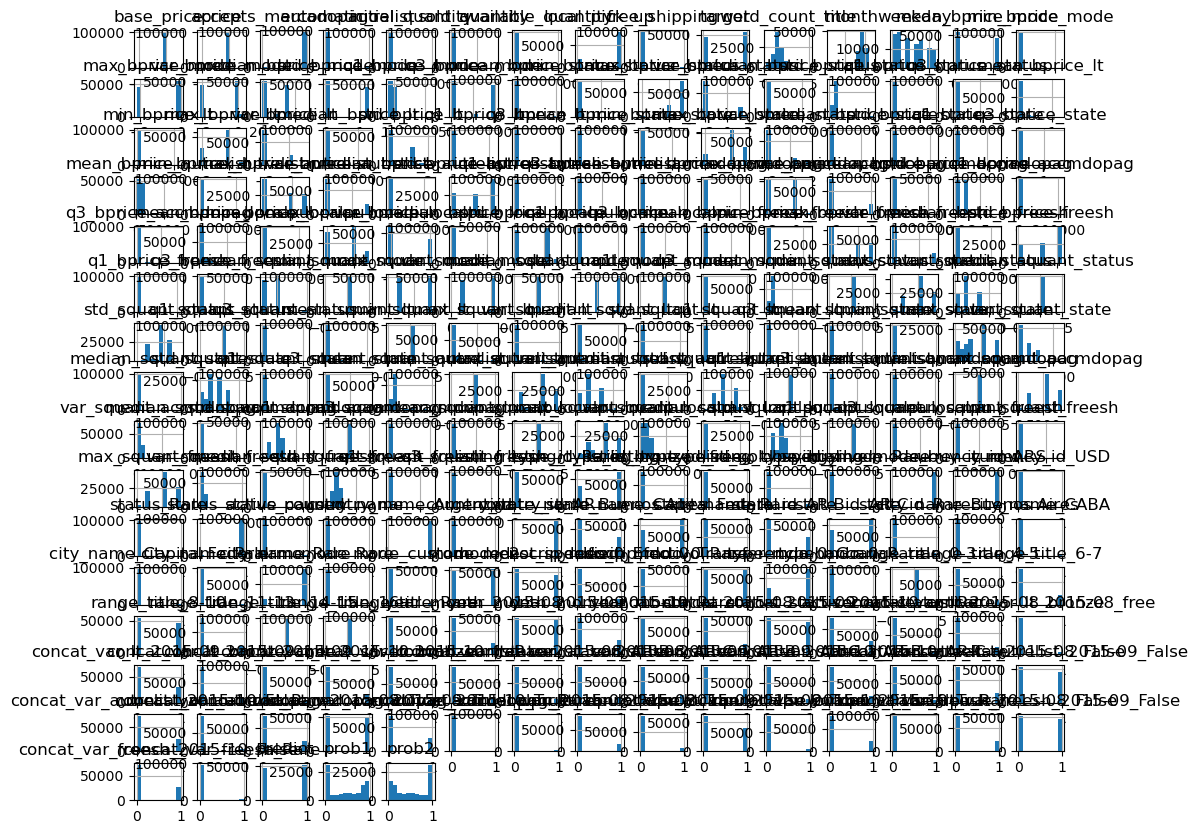

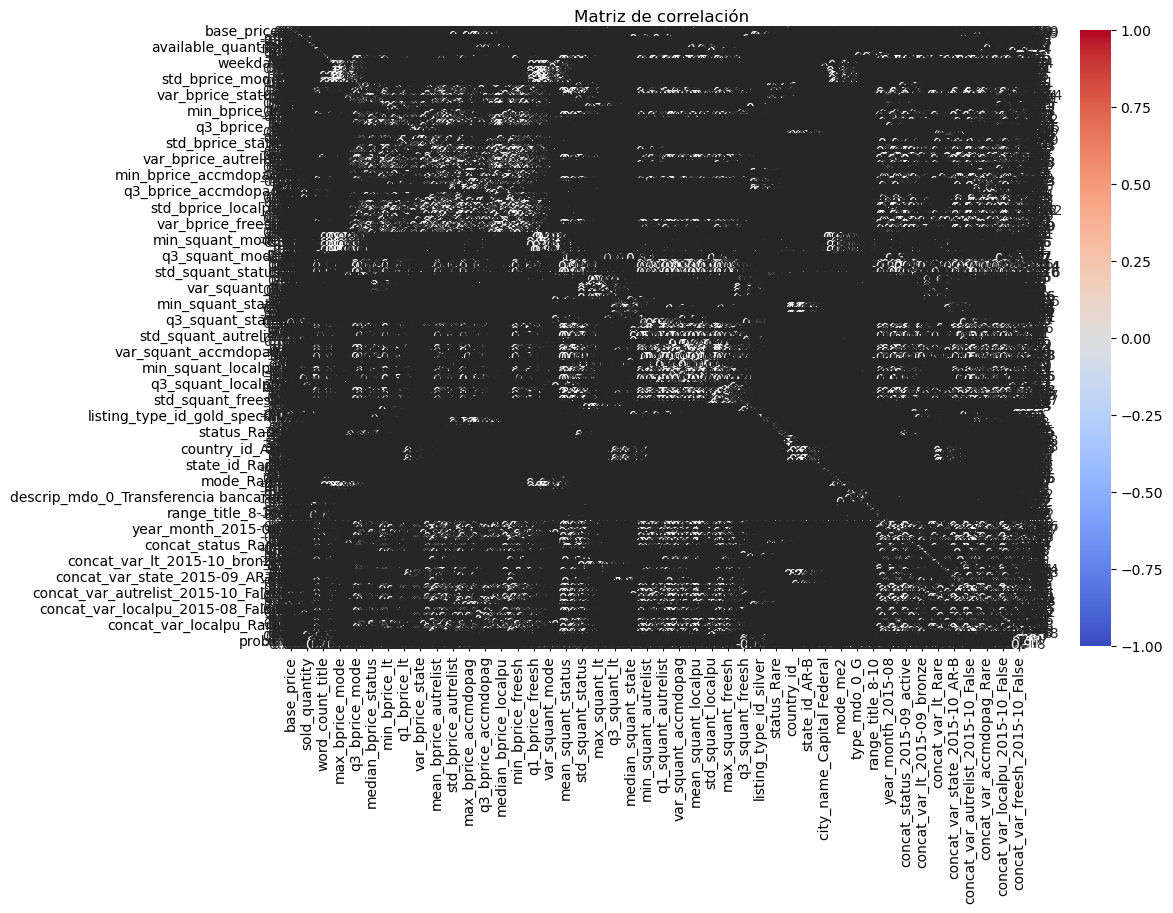

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002D5933D72E0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002D85D8A3380> (for post_execute):


KeyboardInterrupt: 

In [191]:
# Analisis EDA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Ver las primeras filas del conjunto de datos
print(df_total.head())

# Resumen estadístico del conjunto de datos
print(df_total.describe())

# Histogramas de todas las variables numéricas
df_total.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(df_total.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

# Diagrama de dispersión de pares de variables
sns.pairplot(df_total)
plt.show()

# Boxplot de las variables numéricas
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_total)
plt.xticks(rotation=45)
plt.show()

# Análisis de valores faltantes
missing_data = df_total.isnull().sum()
print("Valores faltantes por columna:")
print(missing_data[missing_data > 0])

# Análisis de variables categóricas
for column in df_total.select_dtypes(include=['object']):
    print(f"Valores únicos en {column}:")
    print(df[column].unique())
    print("\n")

In [197]:
##############################
# Variables Significativas
##############################
fi_df = fi_df[fi_df['Importance'] > 0].sort_values(by='Importance', ascending=False)
fi_df

,Feature,Importance
0,base_price,635
9,word_count_title,212
6,available_quantity,166
5,sold_quantity,155
12,mean_bprice_mode,130
...,...,...
91,q3_squant_status,1
144,listing_type_id_silver,1
141,listing_type_id_bronze,1
131,q3_squant_localpu,1


In [213]:
best_model

LGBMClassifier(alpha=0.05, colsample_bytree=0.5, lambda=0.04,
               min_child_weight=0.04, num_leaves=50,
               subsample=0.8999999999999999)

In [215]:
from joblib import dump
# Guardar el modelo en un archivo .pkl 
modelo_file_path = ruta_out + 'modelo.pkl'
dump(best_model, modelo_file_path)

['C:/Users/PERSONAL/Documents/EduGM/ANALYTICS/BD_Modelos/Mercado_Libre/Outputmodelo.pkl']

In [221]:
# Agrupar por la variable 'nivel' y calcular las estadísticas deseadas
analisis_nivel = df_total.groupby('Nivel').agg({
    'price': ['mean', 'min', 'max', 'sum'],
    'sold_quantity': ['mean', 'min', 'max', 'sum']
}).reset_index()

# Renombrar las columnas para mayor claridad
analisis_nivel.columns = ['Nivel', 'price_mean', 'price_min', 'price_max', 'price_sum', 
                          'sold_quantity_mean', 'sold_quantity_min', 'sold_quantity_max', 'sold_quantity_sum']

# Ver el análisis por nivel
print(analisis_nivel)
analisis_nivel.to_excel(os.path.join(ruta_out, 'analisis_nivel.xlsx'), index=False)

   Nivel   price_mean  price_min  price_max  price_sum  sold_quantity_mean  \
0   Bajo  8685.159398          1    5330000  263664069            0.075763   
1  Medio  5798.129482          1    6500000  170743317            0.049613   
2   Alto  2159.034657          0    1919000   86780239            5.869981   

   sold_quantity_min  sold_quantity_max  sold_quantity_sum  
0                  0                982               2300  
1                  0                 20               1461  
2                  0               8676             235938  


C:\Users\PERSONAL\AppData\Local\Temp\ipykernel_4796\1123126342.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analisis_nivel = df_total.groupby('Nivel').agg({
